jupyter notebook --NotebookApp.iopub_data_rate_limit=7368709120

In [1]:
# Reset memory
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Librairies import

In [189]:
# General imports
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import json
import math
import tempfile
import os

from collections import Counter
from scipy.stats import spearmanr, stats
from sklearn.exceptions import ConvergenceWarning
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, roc_auc_score, confusion_matrix, make_scorer, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.feature_selection import SelectPercentile, f_classif, VarianceThreshold, RFE, f_regression
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor

# Oversampling and undersampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Models
import mlflow
import xgboost
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# LIME
import lime
import lime.lime_tabular

# Filter convergence and conditioning warnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

# Set plot preferences
plt.rcParams['figure.max_open_warning'] = 50 
sns.set()



# Data import

In [3]:
df = pd.read_csv('C:/Users/td/implement_scoring_loan/notebook/data.csv')

In [4]:
df.shape

(307507, 797)

In [55]:
def outliers_(df, dev):
    columns_ = df.columns
    outliers_count = {}
    
    for i, variable in enumerate(columns_):
        data = df[variable]
        mean = np.mean(data)
        std = np.std(data)
        iqr = stats.iqr(data)
        
        lim_up = np.quantile(data, 0.75) + 1.5 * iqr
        lim_down = np.quantile(data, 0.25) - 1.5 * iqr

        outliers = data[(data > lim_up) | (data < lim_down)]
        outliers_count[variable] = {'count': len(outliers), 'percent': f"{len(outliers)/len(data)*100:.2f}%"}
    
    return outliers_count

In [6]:
# Split data into target and features

X=df.drop(['TARGET','SK_ID_CURR'],axis=1)
y=df['TARGET']

In [7]:
X.shape, y.shape

((307507, 795), (307507,))

# Exploration 

##  Single values

In [8]:
unique_counts = (X.nunique() == 1).sum()
unique_vars = list(X.columns[X.nunique() == 1])
print(f"{unique_counts} variables have only one unique value:\n{unique_vars}")

31 variables have only one unique value:
['BURO_CREDIT_ACTIVE_nan_MEAN', 'BURO_CREDIT_CURRENCY_nan_MEAN', 'BURO_CREDIT_TYPE_nan_MEAN', 'BURO_STATUS_nan_MEAN_MEAN', 'PREV_NAME_CONTRACT_TYPE_nan_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN', 'PREV_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_NAME_PAYMENT_TYPE_nan_MEAN', 'PREV_CODE_REJECT_REASON_nan_MEAN', 'PREV_NAME_CLIENT_TYPE_nan_MEAN', 'PREV_NAME_GOODS_CATEGORY_House Construction_MEAN', 'PREV_NAME_GOODS_CATEGORY_nan_MEAN', 'PREV_NAME_PORTFOLIO_nan_MEAN', 'PREV_NAME_PRODUCT_TYPE_nan_MEAN', 'PREV_CHANNEL_TYPE_nan_MEAN', 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN', 'PREV_NAME_YIELD_GROUP_nan_MEAN', 'POS_NAME_CONTRACT_STATUS_nan_MEAN', 'CC_SK_DPD_MIN', 'CC_SK_DPD_DEF_MIN', 'CC_NAME_CONTRACT_STATUS_Approved_MIN', 'CC_NAME_CONTRACT_STATUS_Demand_MIN', 'CC_NAME_CONTRACT_STATUS_Refused_MIN', 'CC_NAME_CONTRACT_STATUS_Sent proposal_MIN', 'CC_NAME_CONTRACT_STATUS_nan_MIN'

In [9]:
#  If columns with single value >> Drop
X = X.drop(columns=unique_vars, axis=1)
X.shape

(307507, 764)

## Split dataset 

In [10]:
# Split data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

In [11]:
X_train.shape

(246005, 764)

##  Infinite value

In [16]:
inf_mask = np.isinf(df)
inf_cols = inf_mask.any()
inf_col_names = inf_cols.index[inf_cols].tolist()
print("names columns with inf values :", inf_col_names)


inf_counts = inf_mask.sum()
inf_counts = inf_counts[inf_cols].tolist()
print("number of inf values :", inf_counts)

names columns with inf values : ['PREV_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MAX']
number of inf values : [1, 1, 18]


In [17]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

## Missing values

In [18]:
y_train.isna().sum()

0

In [19]:
X_train.isna().sum()

CODE_GENDER                                 0
FLAG_OWN_CAR                                0
FLAG_OWN_REALTY                             0
CNT_CHILDREN                                0
AMT_INCOME_TOTAL                            0
                                        ...  
CC_NAME_CONTRACT_STATUS_Signed_MAX     176409
CC_NAME_CONTRACT_STATUS_Signed_MEAN    176409
CC_NAME_CONTRACT_STATUS_Signed_SUM     176409
CC_NAME_CONTRACT_STATUS_Signed_VAR     176915
CC_COUNT                               176409
Length: 764, dtype: int64

In [23]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_cleaned = pd.DataFrame(imputer.fit_transform(X_train),columns = X_train.columns)

In [24]:
X_train_cleaned.isna().sum().sum()

0

##  Imbalanced Class

In [25]:
# summarize the class distribution
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d -- Count=%d -- Percentage=%.2f%%' % (k, v, per))

Class=0 -- Count=226108 -- Percentage=73.53%
Class=1 -- Count=19897 -- Percentage=6.47%


In [26]:
# Équilibrage des données en utilisant SMOTE
# over = SMOTE(sampling_strategy=0.1)
under= RandomUnderSampler(sampling_strategy=0.5)
over = SMOTE(sampling_strategy=0.1)
steps = [['o',over],['u',under]]
sampling_pipeline = ImbPipeline(steps=steps)

# transform the dataset
X_train_resampled, y_train_resampled= sampling_pipeline.fit_resample(X_train_cleaned, y_train)

In [27]:
# summarize the resampled class distribution
counter = Counter(y_train_resampled)
for k,v in counter.items():
    per = v / len(y_train_resampled) * 100
    print('Class=%d -- Count=%d -- Percentage=%.2f%%' % (k, v, per))

Class=0 -- Count=45220 -- Percentage=66.67%
Class=1 -- Count=22610 -- Percentage=33.33%


## Zoom : Correlation

### Correlation features with target

<AxesSubplot:>

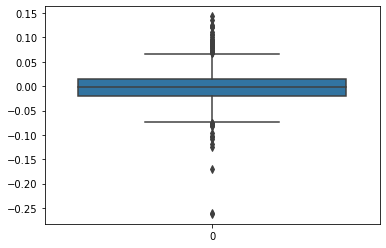

In [30]:
df_corr = pd.concat([X_train_resampled, y_train_resampled], axis=1)

# Calculate the correlation between each feature and the target variable
corr_with_y = df_corr.corrwith(df_corr.iloc[:, -1])
corr_with_y = corr_with_y.drop(['TARGET'])
# Print the correlation coefficients in descending order
sns.boxplot(data = corr_with_y)

In [31]:
corr_with_y.min(), corr_with_y.max()

(-0.2622374458589714, 0.14364113440158816)

### Feature with feature

In [27]:
# # select only binary columns
# binary_features = X_train_resampled.select_dtypes(include=['int']).columns

# # select non-binary columns
# non_binary_features = X_train_resampled.columns[~X_train_resampled.columns.isin(binary_features)]

# # compute correlation matrix for non-binary features
# corr_without_binary = X_train_resampled[non_binary_features].corr()

In [32]:
corr_matrix = X_train_resampled.corr()

c:\users\td\appdata\local\programs\python\python39\lib\site-packages\matplotlib\axes\_axes.py:6731: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\users\td\appdata\local\programs\python\python39\lib\site-packages\matplotlib\axes\_axes.py:6732: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


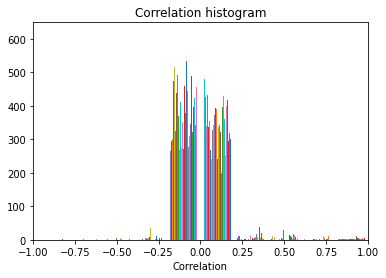

In [37]:
# warnings caused by binary features
plt.hist(corr_matrix, bins=10)
plt.xlim(-1, 1)
plt.xlabel('Correlation')
plt.title('Correlation histogram')
plt.show()

###  Correlation up to 0.8 and under -0.8

In [38]:
threshold = 0.80
correlated_features = set()
# iterate over the lower triangle of the correlation matrix
for i in range(1, len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

In [39]:
len(correlated_features)

238

In [40]:
# Drop features with high correlation
X_train_corr = X_train_resampled.drop(labels=correlated_features, axis=1)

In [41]:
X_train_corr.shape, X_train_resampled.shape

((67830, 526), (67830, 764))

## Variance and outliers

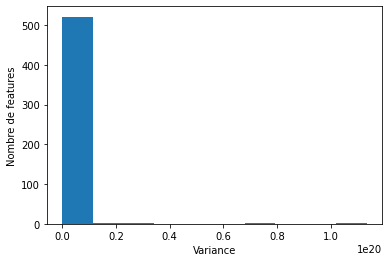

In [42]:
variances = np.var(X_train_corr, axis=0)

# Définir les intervalles de variance
bins = np.linspace(np.min(variances), np.max(variances), 100)

# Calculer le nombre de features par intervalle de variance
hist, _ = np.histogram(variances, bins=bins)

# Créer l'histogramme
plt.hist(variances)
plt.xlabel('Variance')
plt.ylabel('Nombre de features')
plt.show()

In [43]:
variances.min(), variances.max()

(0.0, 1.134407770178366e+20)

In [44]:
np.count_nonzero(variances ==0), np.count_nonzero(variances >0.04e+20)

(3, 5)

### Variance equal to zero 

In [45]:
[variances[variances==0].index]

[Index(['FLAG_MOBIL', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12'], dtype='object')]

In [46]:
X_train_corr = X_train_corr.drop(variances[variances==0].index, axis=1)

In [47]:
X_train_corr.shape

(67830, 523)

### High variance or outliers

In [56]:
outliers_(X_train_resampled[variances[variances>0.04e+20].index],2)

{'INSTAL_PAYMENT_DIFF_VAR': {'count': 12200, 'percent': '17.99%'},
 'CC_AMT_BALANCE_VAR': {'count': 19498, 'percent': '28.75%'},
 'CC_AMT_CREDIT_LIMIT_ACTUAL_VAR': {'count': 19498, 'percent': '28.75%'},
 'CC_AMT_DRAWINGS_ATM_CURRENT_VAR': {'count': 14440, 'percent': '21.29%'},
 'CC_AMT_PAYMENT_CURRENT_VAR': {'count': 14424, 'percent': '21.26%'}}

## Selection features

In [64]:
percentile = 20
pipeline_selecting_feature = make_pipeline(
    SelectPercentile(score_func=f_regression, percentile=percentile)
)

In [65]:
X_train_selected = pipeline_selecting_feature.fit_transform(X_train_corr, y_train_resampled)

In [104]:
feature_names = (pipeline_selecting_feature.get_feature_names_out())
feature_names.shape

(105,)

# Dummy

In [106]:
clf_dummy = DummyClassifier(random_state=39)
clf_dummy.fit(X_train,y_train)
y_pred = clf_dummy.predict(X_test)

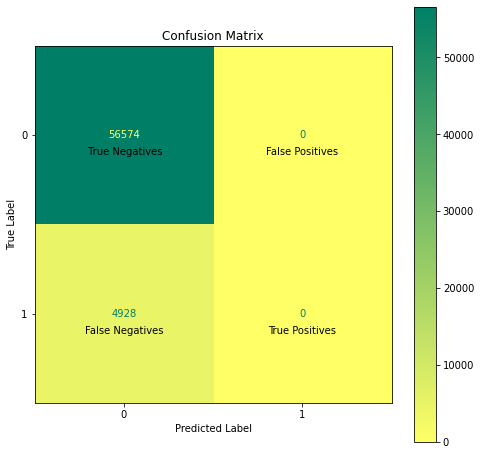

In [107]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Créer un objet ConfusionMatrixDisplay avec la matrice de confusion
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# Afficher la matrice de confusion avec des étiquettes
fig, ax = plt.subplots(figsize=(8, 8))
cm_display.plot(ax=ax, cmap='summer_r')

# Ajouter des étiquettes aux cellules de la matrice de confusion
ax.text(0, 0, '\n True Negatives', ha='center', va='top')
ax.text(0, 1, '\nFalse Negatives',ha='center', va='top')
ax.text(1, 0, '\nFalse Positives',ha='center', va='top')
ax.text(1, 1, '\nTrue Positives',ha='center', va='top')

# Ajouter un titre et des étiquettes d'axe
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label');

# MLFLOW

In [108]:
def score_metier(y_true,y_pred):
    cost_fn = 10 # Coût d'un FN est dix fois supérieur au coût d'un FP
    cost_fp = 1
    # Matrice de confusion pour calculer le nombre de FN et de FP
    confusion_matrix = np.array([[np.sum((y_pred == 0) & (y_true == 0)), np.sum((y_pred == 1) & (y_true == 0))],
                                 [np.sum((y_pred == 0) & (y_true == 1)), np.sum((y_pred == 1) & (y_true == 1))]])
    score_metier = cost_fp * confusion_matrix[0,1] + cost_fn * confusion_matrix[1,0]
    return score_metier

In [109]:
def plot_multi_roc_curve(y_test, y_pred_scores):
    thresholds = np.arange(0, 1.01, 0.1)
    plt.figure(figsize=(10, 6))
    for i, t in enumerate(thresholds):
        y_pred = np.where(y_pred_scores >= t, 1, 0)
        fpr, tpr, _ = roc_curve(y_test, y_pred_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Threshold={t:.1f}, AUC={roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
    plt.xlim([0, 1])
    plt.ylim([0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with Multiple Thresholds')
    plt.legend(loc="lower right")
    plt.show()


In [112]:
cv=KFold(n_splits=5, shuffle=True, random_state=42)

In [113]:
selector = ColumnTransformer(
    transformers=[('select', 'passthrough', feature_names)],
    remainder='drop'
)

cleaning = imputer

preprocessor = PowerTransformer(method='yeo-johnson', standardize=True)

In [114]:
def score_metier_scorer(y_true, y_pred):
    return score_metier(y_true, y_pred)

scorer = make_scorer(score_metier_scorer, greater_is_better=False)


In [ ]:
# def train_model(X_train,y_train,X_test, y_test, model_name,param_name, cv):
#     pipe = Pipeline(steps=[('selector',selector),('cleaning',cleaning),('preprocessor',preprocessor),('model',model_name)])
#     gscv = GridSearchCV(pipe, param_grid=param_name, cv=cv, scoring='accuracy')
#     gscv.fit(X_train, y_train)
#     gscv_best = gscv.best_estimator_
#     run_name = f"{model_name}"
#     with mlflow.start_run(run_name=run_name):
#         mlflow.log_params(gscv.best_params_)
#         mlflow.sklearn.log_model(gscv_best, f"{model_name}-model")
#         y_pred_scores = gscv_best.predict(X_test)

#         mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred_scores))
#         mlflow.log_metric("score_auc", roc_auc_score(y_test, y_pred_scores))

#         probabilities = gscv_best.predict_proba(X_test)
#         threshold = 0.7
#         y_pred = np.where(probabilities[:, 1] >= threshold, 1, 0)
#         mlflow.log_metric('score_metier', score_metier(y_test, y_pred))

#         return gscv_best

In [120]:
def train_model(X_train, y_train, X_test, y_test, model_name, param_name, cv):
    pipe = Pipeline(steps=[('selector', selector), ('cleaning', cleaning), ('preprocessor', preprocessor), ('model', model_name)])
    gscv = GridSearchCV(pipe, param_grid=param_name, cv=cv, scoring=scorer, refit=True)
    gscv.fit(X_train, y_train)
    gscv_best = gscv.best_estimator_
    run_name = f"{model_name}"
    with mlflow.start_run(run_name=run_name):
        mlflow.log_params(gscv.best_params_)
        mlflow.sklearn.log_model(gscv_best, f"{model_name}-model")
        y_pred_scores = gscv_best.predict_proba(X_test)[:, 1]
        y_pred = np.where(y_pred_scores >= 0.5, 1, 0)
        mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
        mlflow.log_metric("score_auc", roc_auc_score(y_test, y_pred))
        mlflow.log_metric('score_metier',score_metier_scorer(y_test, y_pred))

        scores_auc = []
        scores_acc = []
        scores_metier = []
        thresholds = [0.5,0.6,0.7,0.8,0.9]
        for t in thresholds:
            y_pred = np.where(y_pred_scores >= t, 1, 0)
            scores_auc.append(roc_auc_score(y_test, y_pred))
            scores_acc.append(accuracy_score(y_test, y_pred))
            scores_metier.append(score_metier_scorer(y_test, y_pred))
            cm = confusion_matrix(y_test, y_pred)

            # confusion matrice
            cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
            fig, ax = plt.subplots(figsize=(8, 8))
            cm_display.plot(ax=ax, cmap='summer_r')
            ax.text(0, 0, '\n True Negatives', ha='center', va='top')
            ax.text(0, 1, '\nFalse Negatives',ha='center', va='top')
            ax.text(1, 0, '\nFalse Positives',ha='center', va='top')
            ax.text(1, 1, '\nTrue Positives',ha='center', va='top')
            ax.set_title('Confusion Matrix')
            ax.set_xlabel('Predicted Label')
            ax.set_ylabel('True Label')
            
            with tempfile.TemporaryDirectory() as temp_dir:
                name_matrix = run_name+'_'+str(t)
                plot_path = os.path.join(temp_dir,name_matrix+".png")
                plt.savefig(plot_path)
                mlflow.log_artifact(plot_path)

        df_scores = pd.DataFrame({'Threshold': thresholds, 'AUC': scores_auc, 'Accuracy': scores_acc, 'Score_metier': scores_metier})
        print(run_name)
        print(df_scores)

        fig, ax1 = plt.subplots()
        ax1.set_xlabel('Threshold')
        ax1.set_ylabel('AUC / Accuracy', color='black')
        df_scores.plot(kind='bar', x='Threshold', y=['AUC', 'Accuracy'], ax=ax1, color=['red', 'blue'])
        ax1.set_ylim([0.5, 1])
        ax1.legend(loc='lower left')
        ax1.set_title(run_name)

        with tempfile.TemporaryDirectory() as temp_dir:
            plot_path = os.path.join(temp_dir, "auc_acc_plot.png")
            plt.savefig(plot_path)
            mlflow.log_artifact(plot_path)

    # Créer un graphique pour le score métier
        fig, ax2 = plt.subplots()
        ax2.set_xlabel('Threshold')
        ax2.set_ylabel('Score métier', color='green')
        df_scores.plot(kind='bar', x='Threshold', y='Score_metier', ax=ax2, color='green')
        ax2.set_ylim([30000, 50000])
        ax2.legend(loc='lower left')
        ax2.set_title(run_name)

        with tempfile.TemporaryDirectory() as temp_dir:
            plot_path = os.path.join(temp_dir, "score_metier_plot.png")
            plt.savefig(plot_path)
            mlflow.log_artifact(plot_path)


        return gscv_best

    

In [121]:
param_lr = {
    'model__penalty': ['l2'],
    'model__C': [2, 0.001],
    'model__solver': [ 'liblinear'],
    'model__max_iter': [250]
}

param_knn = {'model__n_neighbors': [3, 7]}

param_lgb = {
    'model__boosting_type': ['gbdt'],
    'model__num_leaves': [31, 63],
    'model__learning_rate': [0.05, 0.1],
    'model__n_estimators': [50, 100]}

param_rdmfor = {'model__max_depth': [1000,1],
                'model__min_samples_leaf' : [50,100],
               'model__n_estimators':[9]}
            

In [122]:
# Dictionnaire de classifieurs 
models_ = { 'LogisticRegression':{'model':LogisticRegression(),'params':param_lr},
    'KNN':{'model': KNeighborsClassifier(), 'params': param_knn},
    'LGBMMODEL':{'model': lgb.LGBMClassifier(), 'params': param_lgb},
    'RandomForestClassifier':{'model': RandomForestClassifier(), 'params':param_rdmfor}
              }

LogisticRegression()
   Threshold       AUC  Accuracy  Score_metier
0        0.5  0.657724  0.829875         34736
1        0.6  0.611085  0.884313         38795
2        0.7  0.559237  0.909743         43612
3        0.8  0.519564  0.918377         47392
4        0.9  0.501636  0.919986         49120
KNeighborsClassifier()
   Threshold       AUC  Accuracy  Score_metier
0        0.5  0.587724  0.753748         42199
1        0.6  0.587724  0.753748         42199
2        0.7  0.528975  0.887467         46746
3        0.8  0.528975  0.887467         46746
4        0.9  0.528975  0.887467         46746
LGBMClassifier()
   Threshold       AUC  Accuracy  Score_metier
0        0.5  0.656707  0.806364         35039
1        0.6  0.625746  0.871923         37478
2        0.7  0.574208  0.906784         42183
3        0.8  0.522365  0.918588         47118
4        0.9  0.500723  0.919840         49210
RandomForestClassifier()
   Threshold       AUC  Accuracy  Score_metier
0        0.5  0.62258

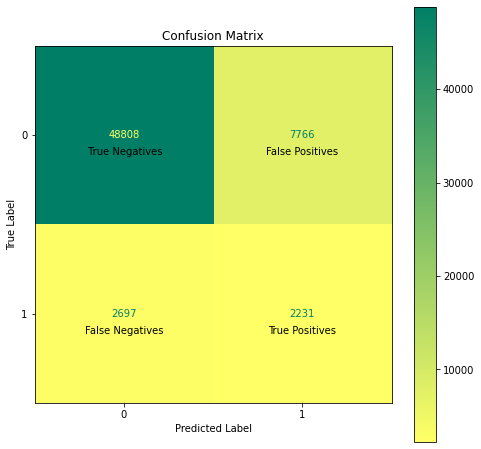

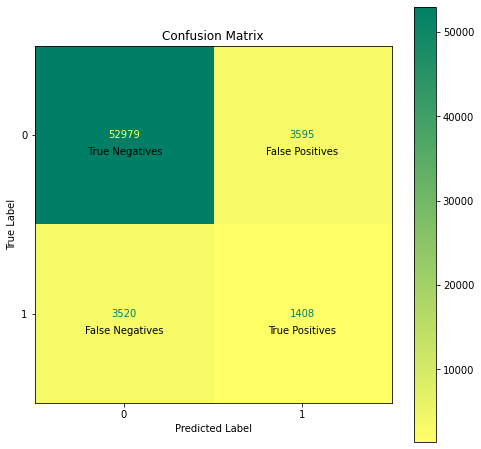

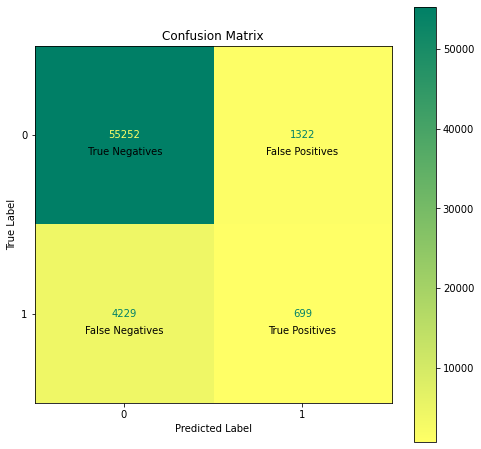

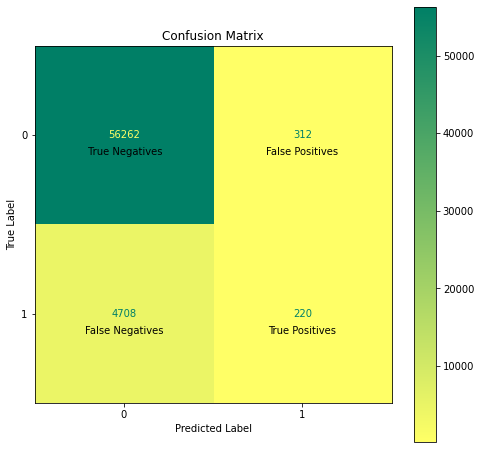

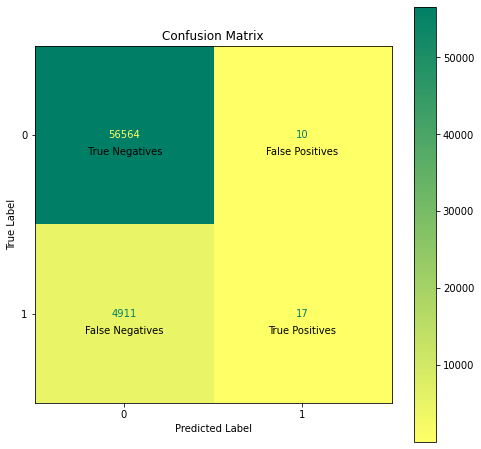

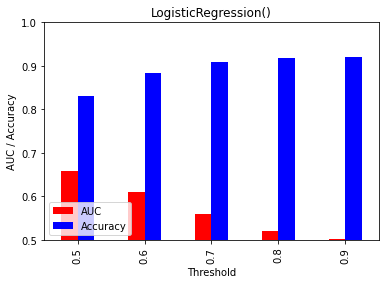

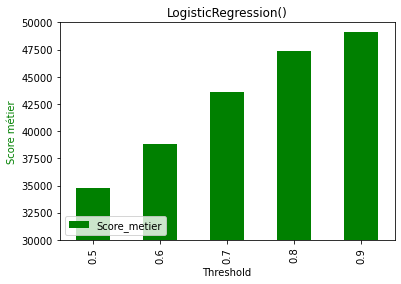

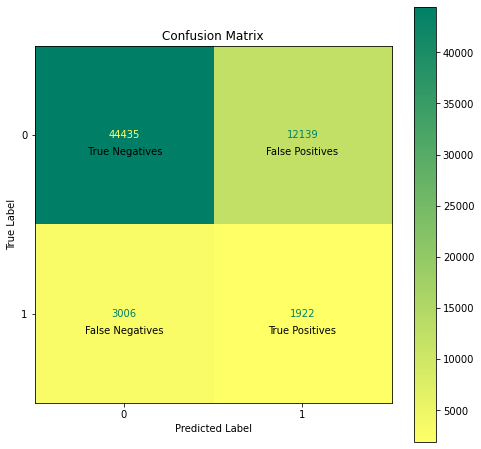

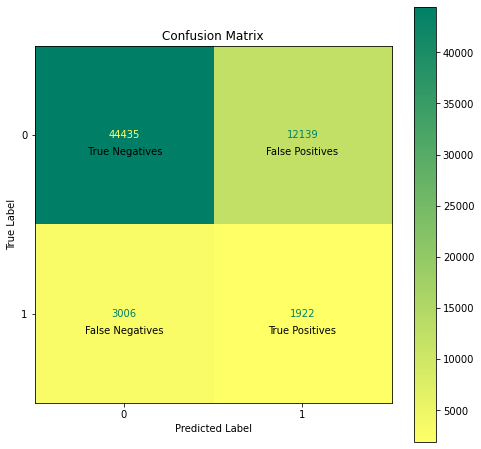

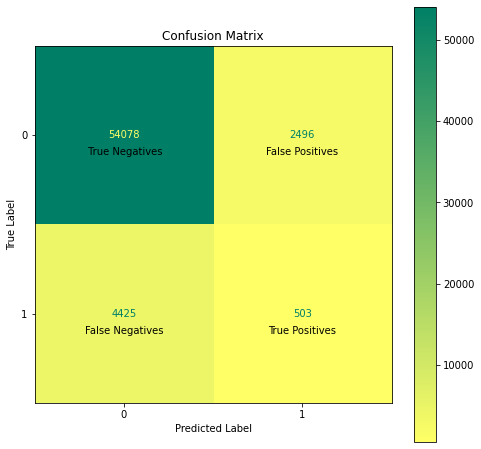

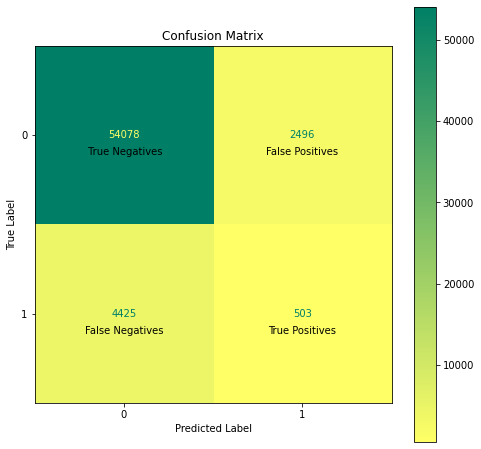

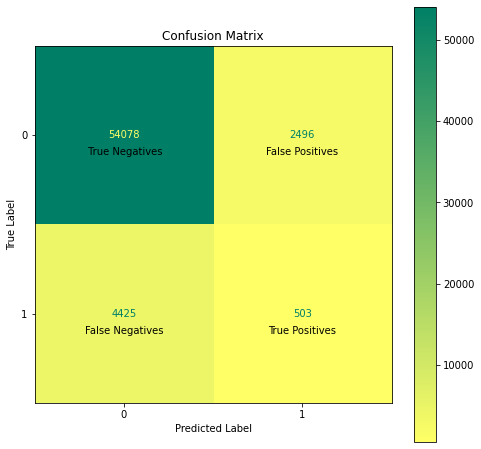

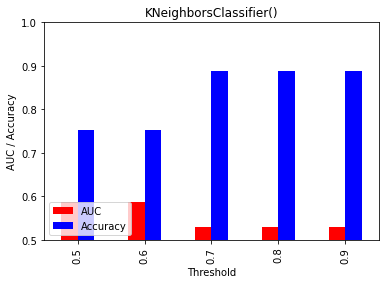

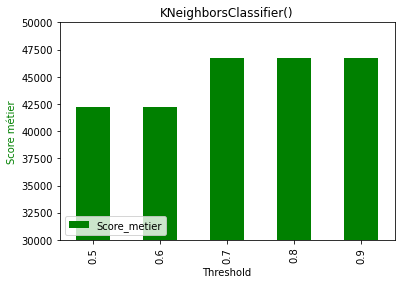

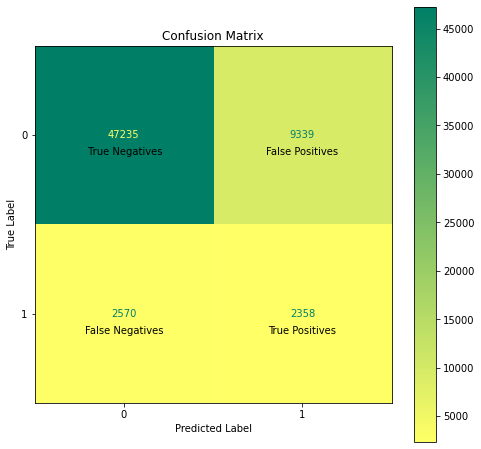

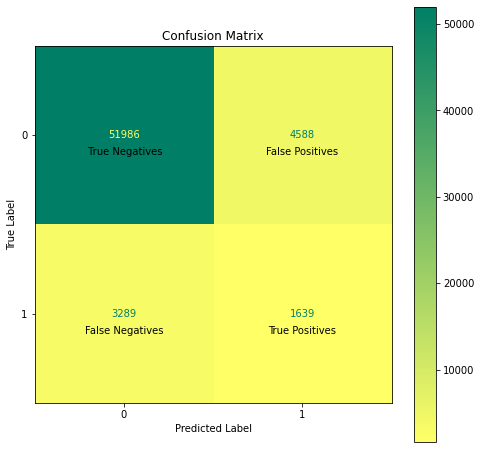

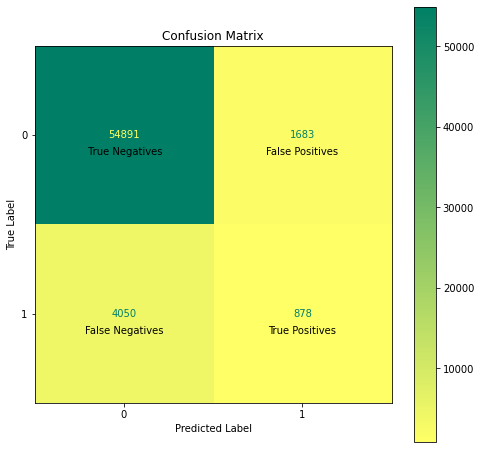

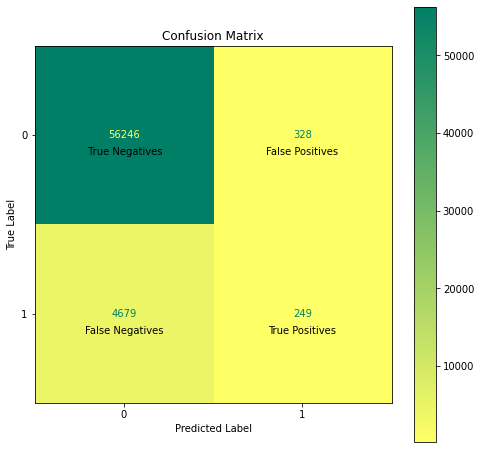

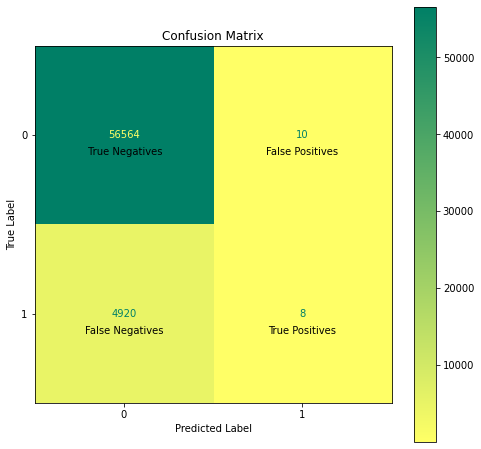

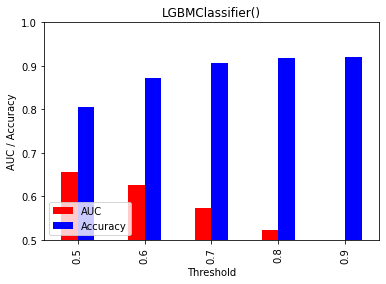

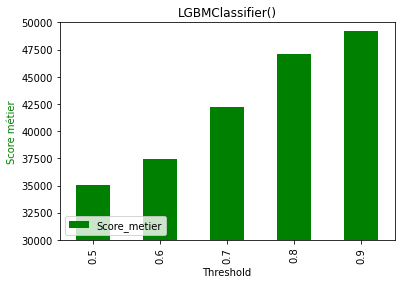

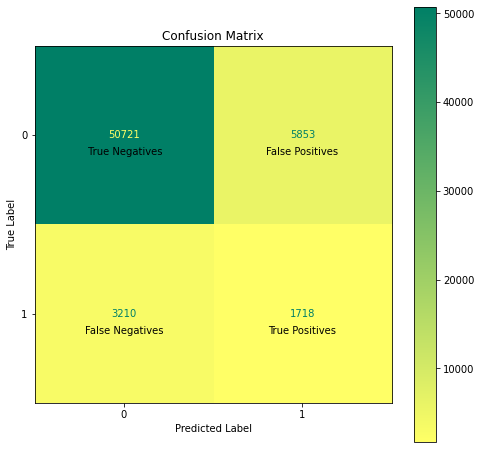

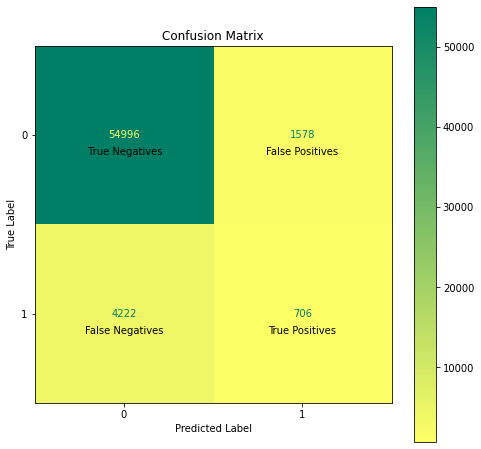

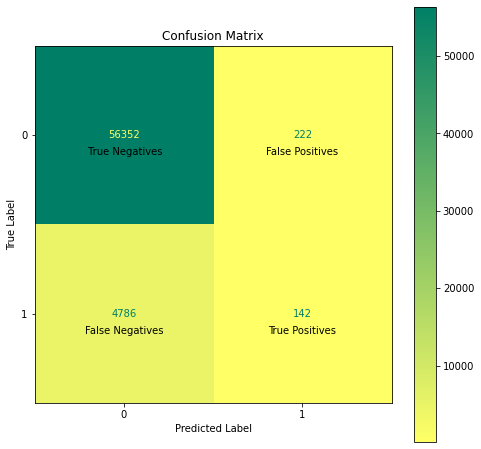

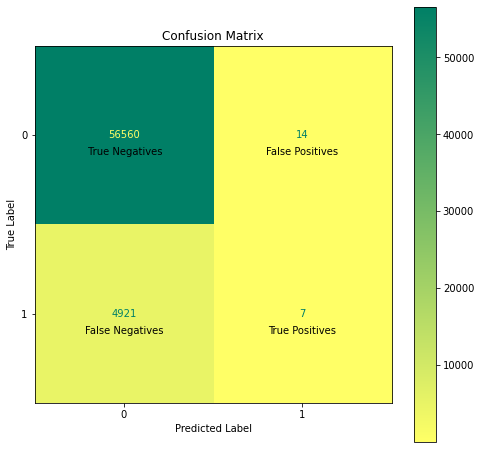

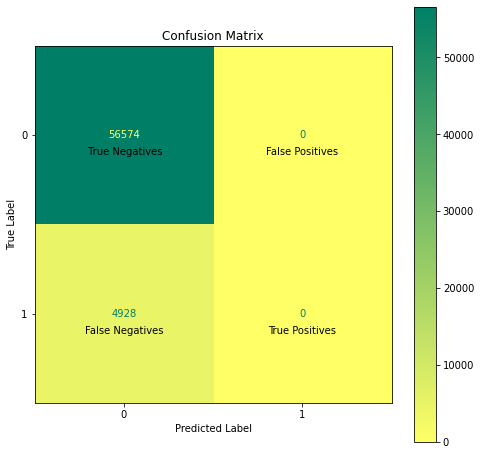

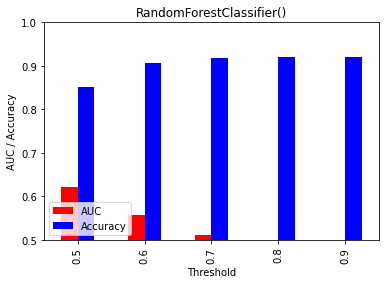

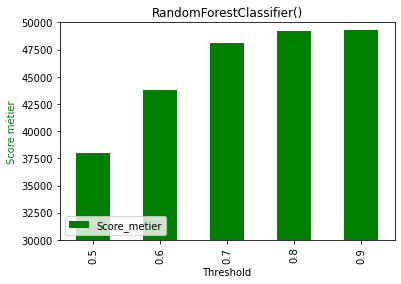

In [125]:
mlflow.set_experiment('classifier_scoring_credit')
for model in models_.keys():
    train_model(X_train_resampled,y_train_resampled,X_test,y_test,models_[model]['model'],models_[model]['params'],cv)

# Model selection

In [127]:
df_experiment = mlflow.search_runs(experiment_ids='931513959754137104', 
                              order_by=["metrics.score_auc DESC"], 
                              max_results=10).sort_values(by=['start_time'])
df_experiment

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.score_auc,metrics.accuracy,metrics.score_metier,params.model__penalty,...,params.model__num_leaves,params.model__min_samples_leaf,params.model__max_depth,params.model__n_neighbors,tags.mlflow.runName,tags.mlflow.log-model.history,tags.mlflow.source.type,tags.mlflow.source.git.commit,tags.mlflow.source.name,tags.mlflow.user
0,c8f06088cfa04ff791bb4e46abeef699,931513959754137104,FINISHED,file:///C:/Users/td/implement_scoring_loan/not...,2023-04-13 08:08:41.383000+00:00,2023-04-13 08:08:47.161000+00:00,0.657724,0.829875,34736.0,l2,...,None,None,None,None,LogisticRegression(),"[{""run_id"": ""c8f06088cfa04ff791bb4e46abeef699""...",LOCAL,fc01337d1b8685b39f826405ad08feab8018b001,c:\users\td\appdata\local\programs\python\pyth...,td
3,b6c536ab30a241e6854e3522f8ba5e67,931513959754137104,FINISHED,file:///C:/Users/td/implement_scoring_loan/not...,2023-04-13 08:11:28.580000+00:00,2023-04-13 08:12:06.550000+00:00,0.587724,0.753748,42199.0,None,...,None,None,None,3,KNeighborsClassifier(),"[{""run_id"": ""b6c536ab30a241e6854e3522f8ba5e67""...",LOCAL,fc01337d1b8685b39f826405ad08feab8018b001,c:\users\td\appdata\local\programs\python\pyth...,td
1,640c36e77acf4566855c7a8ce9741def,931513959754137104,FINISHED,file:///C:/Users/td/implement_scoring_loan/not...,2023-04-13 08:20:42.650000+00:00,2023-04-13 08:20:52.562000+00:00,0.656707,0.806364,35039.0,None,...,63,None,None,None,LGBMClassifier(),"[{""run_id"": ""640c36e77acf4566855c7a8ce9741def""...",LOCAL,fc01337d1b8685b39f826405ad08feab8018b001,c:\users\td\appdata\local\programs\python\pyth...,td
2,55432bfb8a554b8182e215d2c8637f4a,931513959754137104,FINISHED,file:///C:/Users/td/implement_scoring_loan/not...,2023-04-13 08:24:51.195000+00:00,2023-04-13 08:24:59.209000+00:00,0.622581,0.852639,37953.0,None,...,None,50,1000,None,RandomForestClassifier(),"[{""run_id"": ""55432bfb8a554b8182e215d2c8637f4a""...",LOCAL,fc01337d1b8685b39f826405ad08feab8018b001,c:\users\td\appdata\local\programs\python\pyth...,td


In [128]:
df_experiment.iloc[0]

run_id                                             c8f06088cfa04ff791bb4e46abeef699
experiment_id                                                    931513959754137104
status                                                                     FINISHED
artifact_uri                      file:///C:/Users/td/implement_scoring_loan/not...
start_time                                         2023-04-13 08:08:41.383000+00:00
end_time                                           2023-04-13 08:08:47.161000+00:00
metrics.score_auc                                                          0.657724
metrics.accuracy                                                           0.829875
metrics.score_metier                                                        34736.0
params.model__penalty                                                            l2
params.model__C                                                               0.001
params.model__solver                                                      li

In [129]:
# Model selected
json_str = df_experiment['tags.mlflow.log-model.history'].iloc[0]
model_history = json.loads(json_str)
run_id = model_history[0]['run_id']
artifact_path = model_history[0]['artifact_path']

In [131]:
loaded_model = mlflow.sklearn.load_model('runs:/'+run_id+'/'+artifact_path)

## Zoom : definited model

In [132]:
loaded_model

Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('select', 'passthrough',
                                                  array(['CODE_GENDER', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'E...
       'CC_AMT_DRAWINGS_ATM_CURRENT_MEAN', 'CC_AMT_DRAWINGS_CURRENT_MEAN',
       'CC_CNT_DRAWINGS_ATM_CURRENT_MAX',
       'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
       'CC_CNT_DRAWINGS_ATM_CURRENT_SUM', 'CC_CNT_DRAWINGS_CURRENT_MAX',
       'CC_CNT_DRAWINGS_CURRENT_SUM', 'CC_CNT_DRAWINGS_CURRENT_VAR'],
      dtype=object))])),
                ('cleaning', SimpleImputer()),
                ('preprocessor', PowerTransformer()),
                ('model',
                 LogisticRegression(C=0.001, max_iter=250,
                                    solver='liblinear'))])

## Pipeline - Production

In [133]:
## Pipeline preprocessor
pipe_preproc = Pipeline(steps=[('selector',loaded_model.named_steps['selector']),
                               ('cleaning',loaded_model['cleaning']),
                               ('preprocessor',loaded_model['preprocessor'] )])

In [134]:
clf =loaded_model.named_steps['model']

In [135]:
pipe_prod= Pipeline(steps=[('preprocessor',pipe_preproc),
                           ('model',clf)])

In [136]:
pipe_prod

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('selector',
                                  ColumnTransformer(transformers=[('select',
                                                                   'passthrough',
                                                                   array(['CODE_GENDER', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START',
       'REG_CITY_NOT_LIVE_C...
       'CC_CNT_DRAWINGS_ATM_CURRENT_MAX',
       'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
       'CC_CNT_DRAWINGS_ATM_CURRENT_SUM', 'CC_CNT_DRAWINGS_CURRENT_MAX',
       'CC_CNT_DRAWINGS_CURRENT_SUM', 'CC_CNT_DRAWINGS_CURRENT_VAR'],
      dtype=object))])),
                                 ('cleaning', SimpleImputer()),
                                 ('preprocessor', PowerTransformer())])),
                ('model',
                 LogisticRegression(C=0.001, max_iter=250,
                                    solver='liblinear'))])

In [138]:
# Score
y_probabilities = loaded_model.predict_proba(X_test)
y_pred= np.where(y_probabilities[:, 1] >= 0.5, 1, 0)

metier_score = score_metier(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
acc_score = accuracy_score(y_test, y_pred)

print(metier_score,auc_score,acc_score)

34736 0.6577238088408746 0.8298754512048389


Text(0.5, 1.0, 'ROC Curve')

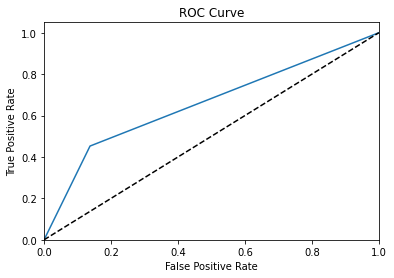

In [139]:
fpr, tpr, seuils = roc_curve(y_test, y_pred)

# Calcul de l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.plot(fpr, tpr, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Random model')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

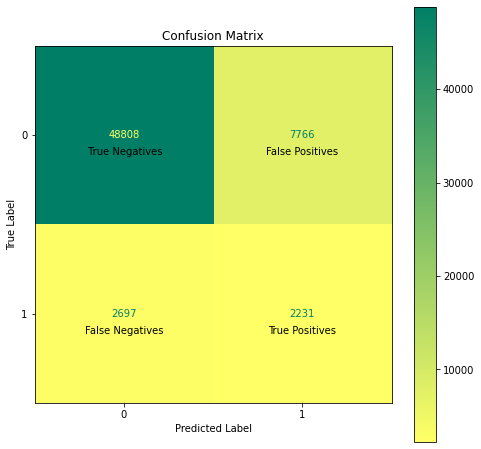

In [140]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Créer un objet ConfusionMatrixDisplay avec la matrice de confusion
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# Afficher la matrice de confusion avec des étiquettes
fig, ax = plt.subplots(figsize=(8, 8))
cm_display.plot(ax=ax, cmap='summer_r')

# Ajouter des étiquettes aux cellules de la matrice de confusion
ax.text(0, 0, '\n True Negatives', ha='center', va='top')
ax.text(0, 1, '\nFalse Negatives',ha='center', va='top')
ax.text(1, 0, '\nFalse Positives',ha='center', va='top')
ax.text(1, 1, '\nTrue Positives',ha='center', va='top')

# Ajouter un titre et des étiquettes d'axe
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label');

# Feature importance

## Global

In [141]:
importance = np.abs(clf.coef_[0])
importance.shape

(105,)

In [148]:
# Normaliser les valeurs pour les faire correspondre à une somme de 1
importance_normalized = importance / np.sum(importance)
importance_normalized.shape

(105,)

In [147]:
feature_names.shape

(105,)

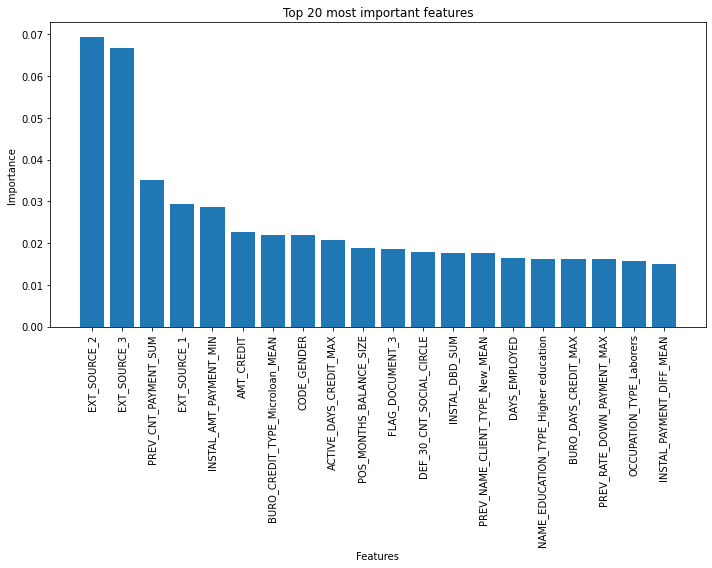

In [172]:
sorted_idx = np.argsort(importance_normalized)[::-1]
sorted_importance = importance_normalized[sorted_idx]
sorted_features = np.array(feature_names)[sorted_idx]

top_n = 20
sorted_importance = sorted_importance[:top_n]
sorted_features = sorted_features[:top_n]

plt.figure(figsize=(10, 8))

plt.bar(range(sorted_features.shape[0]), sorted_importance)
plt.xticks(range(sorted_features.shape[0]), sorted_features, rotation=90)

plt.title('Top 20 most important features')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()



### Local :  Lime explanation

In [173]:
training_data = pipe_preproc.transform(X_train_resampled)
training_data.shape

(67830, 105)

In [174]:
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=training_data,
                                                   feature_names=feature_names,
                                                   class_names=['0','1'],
                                                   discretize_continuous=True)

In [175]:
data_test = pd.read_csv('C:/Users/td/implement_scoring_loan/notebook/data_test.csv')

In [176]:
id_client = 100001
index_client = data_test[data_test['SK_ID_CURR'] == id_client].index[0]
features = data_test.iloc[[index_client]]
features.shape

(1, 794)

In [177]:
test_data = pipe_preproc.transform(features)
test_data.shape

(1, 105)

In [178]:
exp = explainer.explain_instance(test_data.flatten(),
                                 pipe_prod.named_steps['model'].predict_proba, 
                                 num_features=16)

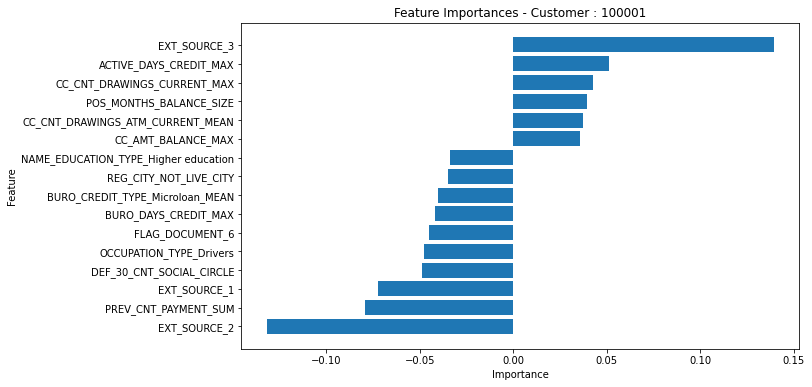

In [180]:
importances = [t[1] for t in exp.as_map()[1]]
selected_indices = [t[0] for t in exp.as_map()[1]]

# Obtenir les noms des colonnes sélectionnées
selected_feature_names = list(pipeline_selecting_feature.get_feature_names_out()[selected_indices])

df_features_importance =  pd.DataFrame(list(zip(selected_feature_names, importances)), 
                                       columns=['Features', 'Importance'])
df_features_importance = df_features_importance.sort_values(by=['Importance'],ascending=True)

# Créer un plot bar
plt.figure(figsize=(10, 6))
plt.barh(range(len(df_features_importance)), df_features_importance['Importance'], align='center')
plt.yticks(range(len(df_features_importance)), df_features_importance['Features'])
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.title(f'Feature Importances - Customer : {id_client}')
plt.show()


# Enregistrement pour fastapi

## Model , explainer and pipe_preprocessor

In [181]:
# Saving model for fastapi

joblib.dump(pipe_prod, 'C:/Users/td/implement_scoring_loan/api/scoring_loan.joblib')

['C:/Users/td/implement_scoring_loan/api/scoring_loan.joblib']

In [182]:
# Explainer
with open('C:/Users/td/implement_scoring_loan/api/explainer.pkl', 'wb') as f:
    dill.dump(explainer, f)

In [183]:
# Explainer
with open('C:/Users/td/implement_scoring_loan/api/preprocessor.pkl', 'wb') as f:
    dill.dump(pipe_preproc, f)

## Data to pytest

In [184]:
index_client = data_test[data_test['SK_ID_CURR'] == 100001].index[0]
features = data_test.iloc[index_client]
data_to_test = features.fillna('missing').to_dict()

In [185]:
json_data = json.dumps(data_to_test)

In [186]:
with open('C:/Users/td/implement_scoring_loan/tests/data/data_to_test.json', 'w') as file :
    file.write(json_data)

In [187]:
exp_proba = exp.predict_proba.tolist()
exp_proba

[0.7947794090763403, 0.20522059092365968]

In [188]:
json_exp = json.dumps(exp_proba)

with open('C:/Users/td/implement_scoring_loan/tests/data/exp_test.json', 'w') as file :
    file.write(json_exp)

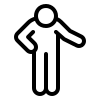

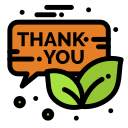